# Introduction

---

This notebook presents an implementation of an analysis method for detecting and understanding artefacts in COLIEE datasets.

---




# Install dependencies

In [ ]:
%pip install datasets

You should consider upgrading via the '/Users/venkateshmurugadas/.pyenv/versions/3.10.0/envs/thesis/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


# Import

In [ ]:
# Standard library imports
from collections import Counter, defaultdict
import string
from typing import List, Tuple
import re

# Third-party imports
from datasets import load_dataset
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
from scipy.stats import norm, binom_test
import spacy
import nltk
nltk.download('punkt')

import pprint


/Users/venkateshmurugadas/.pyenv/versions/3.10.0/envs/thesis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/venkateshmurugadas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Load and preprocess dataset

In [ ]:
# load coliee dataset
data_path = "/Users/venkateshmurugadas/software_codes/nli_artefacts_detection/data/coliee_data/processed/task 4/train/coliee_train_2022.csv"
coliee_train = pd.read_csv(data_path)

In [ ]:
def preprocess(sentence: str) -> List[str]:
    """
    Function to preprocess a given sentence.

    Parameters:
    sentence (str): The sentence to be preprocessed.

    Returns:
    List[str]: List of tokens in the preprocessed sentence.
    """
    # Remove punctuation
    translator = str.maketrans('', '', string.punctuation)
    sentence_no_punct = sentence.translate(translator)

    # Tokenize on whitespace
    tokens = sentence_no_punct.lower().split()

    return tokens

# Apply the preprocess function to the 'hypothesis' column of the DataFrame
# The result is a new column 'tokens' containing the tokenized hypothesis
coliee_train['tokens'] = coliee_train['hypothesis'].apply(preprocess)
# This step is not required as the data is already preprocessed

In [ ]:
coliee_train

,id,label,premise,hypothesis,labels,hyp_tokens,hyp_length,prem_tokens,prem_length,overlap,is_word_overlap,negations,has_negation,detected_subsequence,is_subsequence_heuristic,tokens
0,H18-1-1,1,Article 572\nEven if the seller makes a specia...,A special provision that releases warranty can...,Y,"['a', 'special', 'provision', 'that', 'release...",39,"['article', '572', 'even', 'if', 'the', 'selle...",81,22,True,['not'],True,NaN,False,"[a, special, provision, that, releases, warran..."
1,H18-1-2,0,Article 565\nThe provisions of the preceding t...,There is a limitation period on pursuance of w...,N,"['there', 'is', 'a', 'limitation', 'period', '...",44,"['article', '565', 'the', 'provisions', 'of', ...",176,18,True,['no'],True,NaN,False,"[there, is, a, limitation, period, on, pursuan..."
2,H18-1-3,0,Article 568\n(1) The successful bidder at an a...,"A compulsory auction is also a sale, so warran...",N,"['a', 'compulsory', 'auction', 'is', 'also', '...",20,"['article', '568', '(', '1', ')', 'the', 'succ...",208,10,True,[],False,NaN,False,"[a, compulsory, auction, is, also, a, sale, so..."
3,H18-2-1,1,Article 697\n(1) A person that has begun to ma...,In cases where a person plans to prevent crime...,Y,"['in', 'cases', 'where', 'a', 'person', 'plans...",34,"['article', '697', '(', '1', ')', 'a', 'person...",111,15,True,[],False,NaN,False,"[in, cases, where, a, person, plans, to, preve..."
4,H18-2-2,1,Article 698\nIf a manager engages in benevolen...,In cases where an individual rescues another p...,Y,"['in', 'cases', 'where', 'an', 'individual', '...",45,"['article', '698', 'if', 'a', 'manager', 'enga...",59,16,True,['not'],True,NaN,False,"[in, cases, where, an, individual, rescues, an..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
882,R02-36-I,0,Article 153 (1) The postponement of the expiry...,The postponement of expiry of prescription per...,N,"['the', 'postponement', 'of', 'expiry', 'of', ...",31,"['article', '153', '(', '1', ')', 'the', 'post...",99,29,True,['not'],True,NaN,False,"[the, postponement, of, expiry, of, prescripti..."
883,R02-36-U,1,Article 187 (1) A successor to a possessor may...,A universal successor to a possessor may also ...,Y,"['a', 'universal', 'successor', 'to', 'a', 'po...",16,"['article', '187', '(', '1', ')', 'a', 'succes...",39,14,True,[],False,NaN,False,"[a, universal, successor, to, a, possessor, ma..."
884,R02-36-E,0,Article 254 A claim that one of the co-owners ...,A claim that a co-owner (A) holds against anot...,N,"['a', 'claim', 'that', 'a', 'co-owner', '(', '...",32,"['article', '254', 'a', 'claim', 'that', 'one'...",28,19,True,['not'],True,NaN,False,"[a, claim, that, a, coowner, a, holds, against..."
885,R02-37-A,1,Article 406 If the subject matter of the claim...,If the obligor of an alternative obligation ma...,Y,"['if', 'the', 'obligor', 'of', 'an', 'alternat...",38,"['article', '406', 'if', 'the', 'subject', 'ma...",81,27,True,['not'],True,NaN,False,"[if, the, obligor, of, an, alternative, obliga..."


# Artefacts detection using Z-statistic test

---

This analysis is based on the research paper titled **"Competency Problems: On Finding and Removing Artifacts in Language Data"**.

In NLP tasks, datasets often contain subtle biases or artefacts that models may exploit to make predictions. These biases aren't always evident upon cursory inspection and may lead to overestimated performance metrics as models rely on them rather than learning the intended linguistic phenomena.

The research paper this notebook refers to proposes a method for detecting these dataset artefacts using statistical techniques. **The approach is grounded on the calculation of Z-statistics for each token in the dataset, considering each label. A token with a Z-statistic that significantly deviates from what we would expect under a null hypothesis is considered a potential artefact.**

***This notebook covers the process of loading and preprocessing the dataset, calculating token statistics, and using these statistics to identify potential artefacts.*** It also provides a visualization of these artefacts, offering insights into how they distribute across different labels in the dataset.

---

## Prepare Hypothesis Token statistics

In [ ]:
# Get a list of unique labels in the dataset
labels = coliee_train['labels'].unique().tolist()

In [ ]:
# Initialize Counters
token_counts = Counter()

# token_label_counts is a defaultdict of Counters.
# For each label, it will hold a Counter that contains the count of each token for that label.
token_label_counts = defaultdict(Counter)

for i, row in coliee_train.iterrows():
    token_counts.update(row['tokens'])
    token_label_counts[row['labels']].update(row['tokens'])

# Create a DataFrame for token statistics
token_df = pd.DataFrame.from_dict(token_counts, orient='index', columns=['total_count'])
token_df.index.name = 'token'
token_df.reset_index(inplace=True)

## Calculate Conditional Probabilities for label given token

In [ ]:
# For each label, we add two new columns to the DataFrame:
# 1. A count column, which indicates how many times each token appears with that label
# 2. A probability column, which is the count for each token and label divided by the total count for that token

# Iterate over all unique labels
for label in labels:
    token_df[f'{label}_count'] = token_df['token'].map(token_label_counts[label])
    token_df[f'{label}_prob'] = token_df[f'{label}_count'] / token_df['total_count']


In [ ]:
token_df

,token,total_count,Y_count,Y_prob,N_count,N_prob
0,a,1646,845,0.513366,801,0.486634
1,special,25,15,0.600000,10,0.400000
2,provision,19,12,0.631579,7,0.368421
3,that,441,248,0.562358,193,0.437642
4,releases,5,4,0.800000,1,0.200000
...,...,...,...,...,...,...
2098,successors,3,1,0.333333,2,0.666667
2099,whom,1,0,0.000000,1,1.000000
2100,postpone,1,0,0.000000,1,1.000000
2101,universal,1,1,1.000000,0,0.000000


In [ ]:
token_df.to_csv('/Users/venkateshmurugadas/software_codes/nli_artefacts_detection/data/token_stats_coliee_2022.csv', index=False)

## Calculate Z-Statistics for each token in each label

In [ ]:
# Set the null hypothesis probability
# The null hypothesis in this context is that the labels are evenly distributed among the tokens.
# So, we calculate the probability under the null hypothesis (p0) by dividing 1 by the number of unique labels.
p0 = 1 / len(labels)

'''
Calculate the z-statistics for each label
The z-statistic is a measure of how much the observed probability deviates from the expected probability
under the null hypothesis.
A high absolute value of the z-statistic indicates that the observed probability
significantly deviates from the expected probability, which may suggest the presence of a bias or artifact.
We calculate the z-statistic for each label and add it as a new column in the DataFrame.
'''

# This specific z_stat is not used directly in the analysis (this is done only for reference and understanding)
for label in labels:
    token_df[f'{label}_z_stat'] = (token_df[f'{label}_prob'] - p0) / np.sqrt((p0 * (1 - p0)) / token_df['total_count'])


In [ ]:
token_df

,token,total_count,Y_count,Y_prob,N_count,N_prob,Y_z_stat,N_z_stat
0,a,1646,845,0.513366,801,0.486634,1.084520,-1.084520
1,special,25,15,0.600000,10,0.400000,1.000000,-1.000000
2,provision,19,12,0.631579,7,0.368421,1.147079,-1.147079
3,that,441,248,0.562358,193,0.437642,2.619048,-2.619048
4,releases,5,4,0.800000,1,0.200000,1.341641,-1.341641
...,...,...,...,...,...,...,...,...
2098,successors,3,1,0.333333,2,0.666667,-0.577350,0.577350
2099,whom,1,0,0.000000,1,1.000000,-1.000000,1.000000
2100,postpone,1,0,0.000000,1,1.000000,-1.000000,1.000000
2101,universal,1,1,1.000000,0,0.000000,1.000000,-1.000000


## Calculate the Threshold for rejecting null hypothesis

---

1. Choose a significance level. it's the maximum probability of making a Type I error (false positive) that we're willing to accept.
2. Calculate the number of tests (unique tokens in the DataFrame). We need this for the Bonferroni correction, which adjusts the significance level to control the family-wise error rate when performing multiple tests.
3. Apply the Bonferroni correction. The Bonferroni correction is a method used to counteract the problem of multiple comparisons.It adjusts the significance level by dividing it by the number of tests. This makes the significance threshold more stringent, reducing the probability of false positives.
4. Calculate the z-statistic threshold. The z-statistic threshold is the value that the z-statistic must exceed for us to reject the null hypothesis at the chosen significance level. It's calculated using the inverse of the cumulative distribution function (quantile function) of the standard normal distribution.
5. Calculate the overall threshold above which the null hypothesis can be rejected.Tokens with an observed probability greater than this threshold are considered significant at the chosen significance level. This line ensures the threshold is between 0 and 1 by applying the np.minimum and np.maximum functions.
6. Calculate the threshold for each token. This calculation is similar to the overall threshold calculation but it's done for each token individually.
The resulting 'threshold' column in the DataFrame gives the threshold for each token.

---

In [ ]:
alpha = 0.01
num_tests = len(token_df)

# do the correction only when the number of tests are larger
# alpha_bonferroni = alpha / num_tests

# Calculate the z-statistic threshold
z_star = norm.ppf(1 - alpha / 2)

# Calculate the overall threshold
threshold = np.minimum(1, np.maximum(0, p0 + z_star / (2 * np.sqrt(token_df['total_count'].sort_values()))))

# Calculate the threshold for each token
token_df['threshold'] = np.minimum(1, np.maximum(0, p0 + z_star / (2 * np.sqrt(token_df['total_count']))))

# token_df['threshold'] = p0 + z_star * np.sqrt((p0 * (1 - p0)) / token_df['total_count'])




In [ ]:
z_star

2.5758293035489004

In [ ]:
token_df

,token,total_count,Y_count,Y_prob,N_count,N_prob,Y_z_stat,N_z_stat,threshold
0,a,1646,845,0.513366,801,0.486634,1.084520,-1.084520,0.531745
1,special,25,15,0.600000,10,0.400000,1.000000,-1.000000,0.757583
2,provision,19,12,0.631579,7,0.368421,1.147079,-1.147079,0.795468
3,that,441,248,0.562358,193,0.437642,2.619048,-2.619048,0.561329
4,releases,5,4,0.800000,1,0.200000,1.341641,-1.341641,1.000000
...,...,...,...,...,...,...,...,...,...
2098,successors,3,1,0.333333,2,0.666667,-0.577350,0.577350,1.000000
2099,whom,1,0,0.000000,1,1.000000,-1.000000,1.000000,1.000000
2100,postpone,1,0,0.000000,1,1.000000,-1.000000,1.000000,1.000000
2101,universal,1,1,1.000000,0,0.000000,1.000000,-1.000000,1.000000


# Binomial Test for Language Artefact Recognition

/var/folders/w5/q2d0spjx14x5z8h5hlljhxfr0000gn/T/ipykernel_15836/2240852927.py:10: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  token_df['Y_p_value'] = token_df.apply(lambda row: binom_test(row['Y_count'], row['total_count'], p0, alternative='greater'), axis=1)
/var/folders/w5/q2d0spjx14x5z8h5hlljhxfr0000gn/T/ipykernel_15836/2240852927.py:11: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  token_df['N_p_value'] = token_df.apply(lambda row: binom_test(row['N_count'], row['total_count'], p0, alternative='greater'), axis=1)


Number of tokens biased in Y: 93
Number of tokens biased in N: 52


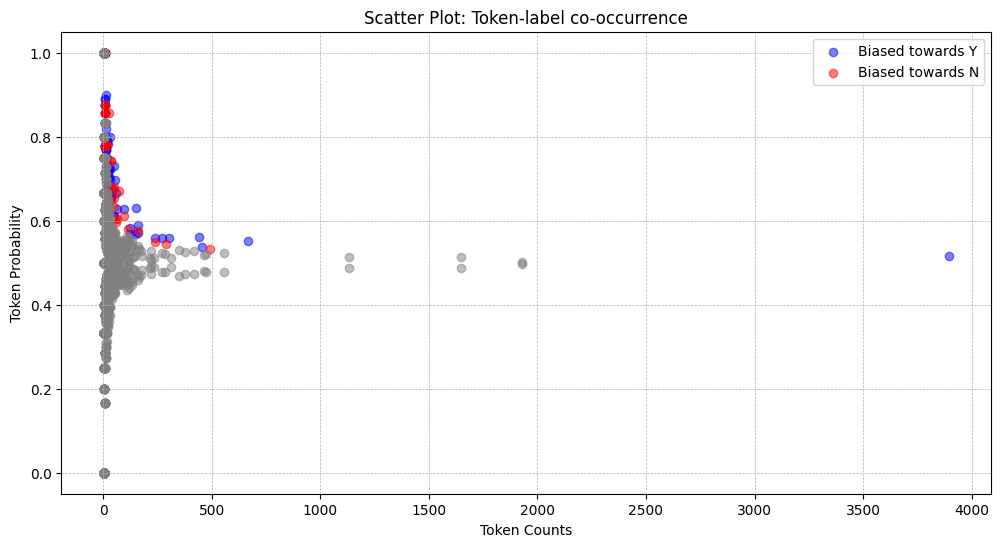

In [ ]:
## Binomial Test for Language Artifact Recognition

# Define significance level
alpha = 0.1

# p0 is the null hypothesis probability
p0 = 1 / len(labels)

# Calculate the p-value for each token
token_df['Y_p_value'] = token_df.apply(lambda row: binom_test(row['Y_count'], row['total_count'], p0, alternative='greater'), axis=1)
token_df['N_p_value'] = token_df.apply(lambda row: binom_test(row['N_count'], row['total_count'], p0, alternative='greater'), axis=1)

# Identify tokens biased towards 'Y' and 'N'
tokens_biased_Y = [row['token'] for _, row in token_df.iterrows()
                   if row['Y_prob'] > 0.5 and row['Y_p_value'] < alpha]

tokens_biased_N = [row['token'] for _, row in token_df.iterrows()
                   if row['N_prob'] > 0.5 and row['N_p_value'] < alpha]

# Extract data for plotting
df_Y_biased = token_df[token_df['token'].isin(tokens_biased_Y)]
df_N_biased = token_df[token_df['token'].isin(tokens_biased_N)]

# sort the dataframes based on the Y and N counts
df_Y_biased = df_Y_biased.sort_values(by=['Y_count'], ascending=False)
df_N_biased = df_N_biased.sort_values(by=['N_count'], ascending=False)

# Number of biased tokens in Y
print(f"Number of tokens biased in Y: {df_Y_biased.shape[0]}")
# Number of biased tokens in N
print(f"Number of tokens biased in N: {df_N_biased.shape[0]}")

# Scatter plot for visualizing biased tokens and other tokens
plt.figure(figsize=(12, 6))

# Tokens biased towards 'Y'
plt.scatter(df_Y_biased['total_count'], df_Y_biased['Y_prob'], color='blue', label='Biased towards Y', alpha=0.5)
# Tokens biased towards 'N'
plt.scatter(df_N_biased['total_count'], df_N_biased['N_prob'], color='red', label='Biased towards N', alpha=0.5)

# Other tokens
df_others = token_df[~token_df['token'].isin(tokens_biased_Y + tokens_biased_N)]
plt.scatter(df_others['total_count'], df_others['Y_prob'], color='gray', alpha=0.5)
plt.scatter(df_others['total_count'], df_others['N_prob'], color='gray', alpha=0.5)

# Configure the plot
plt.xlabel('Token Counts')
plt.ylabel('Token Probability')
plt.title('Scatter Plot: Token-label co-occurrence')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


In [ ]:
df_Y_biased.to_clipboard(index=False)

In [ ]:
df_N_biased.to_clipboard(index=False)

In [ ]:
pprint.pprint(df_Y_biased['token'].to_list())

['that',
 'can',
 'in',
 'are',
 'the',
 'hisher',
 'for',
 'released',
 'cases',
 'person',
 'fence',
 'car',
 'it',
 'with',
 'reimbursement',
 'repair',
 'fees',
 'established',
 'employer',
 'liability',
 'appointment',
 'supervision',
 'interest',
 'mortgagee',
 'without',
 'or',
 'two',
 'maximum',
 'building',
 'advance',
 'perform',
 'into',
 'certain',
 'relieved',
 'any',
 'payments',
 'joint',
 'several',
 'such',
 'cancellation',
 'possessor',
 'possession',
 'faith',
 'title',
 'owned',
 'nature',
 'good',
 'owner',
 'together',
 'fruits',
 'mandatary',
 'mandator',
 'incurred',
 'extent',
 'actually',
 'principle',
 'assume',
 'work',
 'assets',
 'rescinded',
 'permission',
 'reimburse',
 'distributed',
 'recovery',
 'enters',
 'markers',
 'construction',
 'necessary',
 'obligations',
 'ordering',
 'assignee',
 'refuse',
 'defect',
 'fails',
 'administration',
 'contractor',
 'refused',
 'her',
 'assumed',
 'tendering',
 'yen',
 'latent',
 'lieu',
 'thirdparty',
 'stole',

In [ ]:
pprint.pprint(df_N_biased['token'].to_list())

['not',
 'sale',
 'an',
 'their',
 'must',
 'property',
 'even',
 'authority',
 'real',
 'do',
 'take',
 'priority',
 'rank',
 'cannot',
 'contract',
 'elapsed',
 'effect',
 'was',
 'unless',
 'per',
 'return',
 'rescind',
 'heir',
 'inherited',
 'pledge',
 'parties',
 'pledgor',
 'visavis',
 'cause',
 'need',
 'among',
 'gross',
 'tree',
 'branch',
 'identified',
 'choice',
 'conclusion',
 'tendered',
 'anything',
 'arrived',
 'juridical',
 'wrong',
 'mental',
 'consents',
 'subordinated',
 'died',
 'manifests',
 'release',
 'settlement',
 'belong',
 'mortgagees',
 'regard']


In [ ]:
df_N_biased

,token,total_count,Y_count,Y_prob,N_count,N_prob,Y_z_stat,N_z_stat,threshold
48,sale,95,37,0.389474,58,0.610526,-2.154555,2.154555,0.632137
102,property,70,23,0.328571,47,0.671429,-2.868549,2.868549,0.653935
129,even,160,68,0.425000,92,0.575000,-1.897367,1.897367,0.601819
167,real,35,9,0.257143,26,0.742857,-2.873524,2.873524,0.717697
171,do,35,9,0.257143,26,0.742857,-2.873524,2.873524,0.717697
178,take,18,4,0.222222,14,0.777778,-2.357023,2.357023,0.803564
184,rank,5,0,0.000000,5,1.000000,-2.236068,2.236068,1.000000
259,cannot,49,18,0.367347,31,0.632653,-1.857143,1.857143,0.683988
286,elapsed,6,0,0.000000,6,1.000000,-2.449490,2.449490,1.000000
287,effect,50,16,0.320000,34,0.680000,-2.545584,2.545584,0.682139


In [ ]:
from functools import reduce
# find similar words

def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3


y_biased_tokens = df_Y_biased['token'].to_list()
n_biased_tokens = df_N_biased['token'].to_list()

biased_on_both = intersection(y_biased_tokens, n_biased_tokens)
biased_on_both

[]

# Plot Interactive Artefacts map

In [ ]:
# Create an interactive scatter plot using Plotly

# Define a new figure
fig = go.Figure()

# Define a dictionary of colors for each label
colors = {'Y': 'green', 'N': 'red', 'grey': 'grey'}

# Plot the observed probabilities for each token and label
for label in labels:
    # Get the DataFrame for the current label
    data_label = token_df

    # Determine which points are above the threshold
    # This creates a Boolean Series where each element is True if the observed probability is
    # above the threshold, and False otherwise
    is_above_threshold = data_label[f'{label}_prob'] > data_label['threshold']

    # Add scatter plots for points above and below the threshold
    # Points above the threshold are colored according to the label, and
    # points below the threshold are colored grey
    for condition, color in zip([is_above_threshold, ~is_above_threshold], [colors[label], 'grey']):
        token = data_label[condition]['token']
        text = [f"Label: {label}<br>Token: {t}" for t in token]
        fig.add_trace(go.Scatter(
            x = data_label[condition]['total_count'],
            y = data_label[condition][f'{label}_prob'],
            mode = 'markers',
            name = label if color != 'grey' else None,
            marker = dict(
                color = color,
                size = 4
            ),
            text = text,
            hovertemplate = "%{text}<br>Occurrences: %{x}<br>Observed probabilities: %{y}<extra></extra>"
        ))

# Add the threshold line to the plot
fig.add_trace(go.Scatter(
    x = token_df['total_count'].sort_values(),
    y = threshold,
    mode = 'lines',
    name = f'alpha={alpha}/{num_tests}',
    line = dict(color='blue')
))

# Set the scale of the x-axis to logarithmic and limit its range
fig.update_xaxes(type='log', range=[0.8, np.log10(max(token_df['total_count']))])

# Set the labels for the x and y axes, and the title for the plot
fig.update_layout(
    xaxis_title='n',
    yaxis_title='p(y|x)',
    title='Artefacts in SNLI dataset'
)

# Display the plot
fig.show()


In [ ]:
fig.write_html('plots/2018/train/coliee_2018_artefacts_interactive_chart.html')

# Plot Static Map

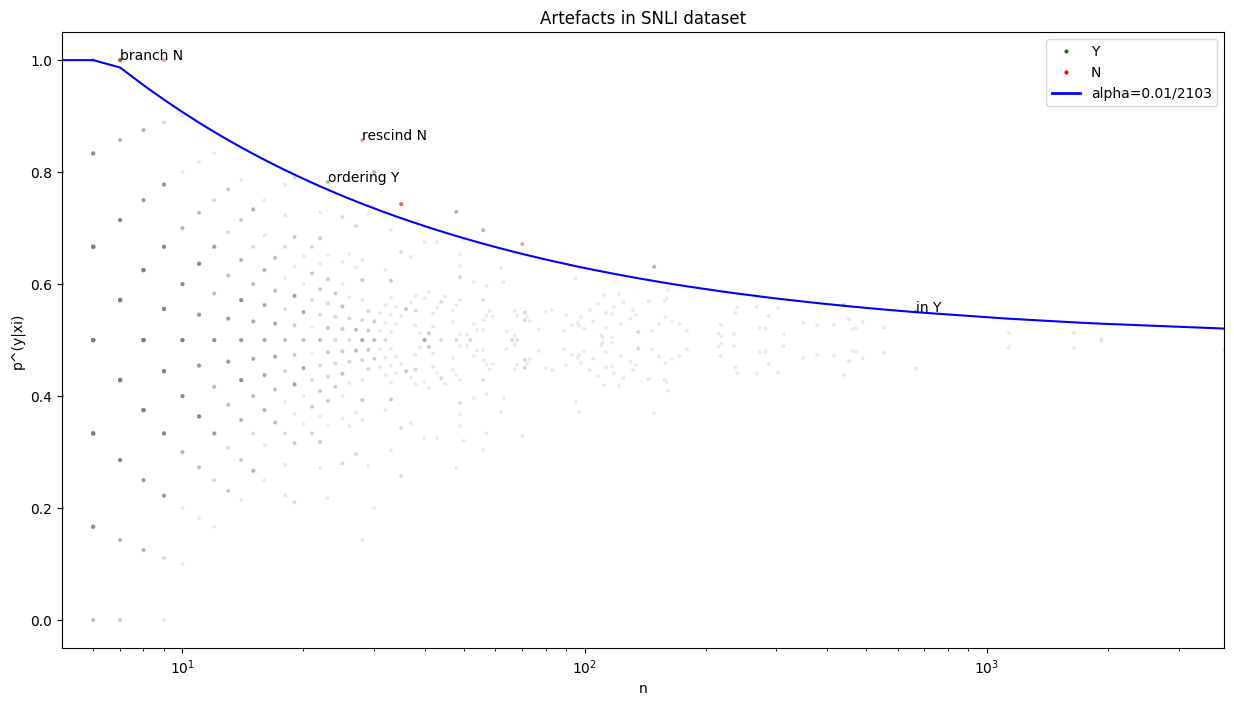

In [ ]:
# Define the figure and axes for the plot
fig, ax = plt.subplots(figsize=(15,8))

# Define a dictionary of colors for each label
colors = {'Y': 'g', 'N': 'r', 'grey': 'grey'}

# Define a dictionary of words to annotate in the plot for each label
token_label_annotate_dict = {
    'N': ['rescind', 'branch'],
    'Y': ['in', 'ordering']
}

# Plot the observed probabilities for each token and label
for label in labels:
    # Create a condition series to find which points are above the threshold
    is_above_threshold = token_df[f'{label}_prob'] > token_df['threshold']

    # Create a color and alpha series based on the condition series
    color_series = pd.Series(colors['grey'], index=token_df.index)
    color_series[is_above_threshold] = colors[label]

    alpha_series = pd.Series(0.1, index=token_df.index)
    alpha_series[is_above_threshold] = 0.3

    # Plot the points for this label
    ax.scatter(token_df['total_count'], token_df[f'{label}_prob'], c=color_series, alpha=alpha_series, s=4)

    # # Add annotations for selected words
    for token in set(token_label_annotate_dict[label]) & set(token_df['token']):
        x = token_df.loc[token_df['token'] == token, 'total_count'].values[0]
        y = token_df.loc[token_df['token'] == token, f'{label}_prob'].values[0]
        ax.annotate(f'{token} {label[0]}', (x, y))

# Add the threshold line to the plot
ax.plot(token_df['total_count'].sort_values(), threshold, 'b-', label=f'alpha=0.01/{num_tests}')

# Adjust x-axis to be logarithmic and limit its range
ax.set_xscale('log')
ax.set_xlim([10**0.7, max(token_df['total_count'])])

# Hide the first x-axis label
ax.xaxis.get_major_ticks()[0].label1.set_visible(False)

# Set the labels for the x and y axes, and the title for the plot
ax.set_xlabel('n')
ax.set_ylabel('p^(y|xi)')
ax.set_title('Artefacts in SNLI dataset')

# Create custom legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label=label,
                          markerfacecolor=color, markersize=4) for label, color in colors.items() if label != 'grey']
legend_elements.append(Line2D([0], [0], color='b', lw=2, label=f'alpha={alpha}/{num_tests}'))  # Add threshold line to legend
ax.legend(handles=legend_elements, loc='upper right')

# Display the plot
plt.show()


In [ ]:
plt.savefig('plots/2018/train/coliee_2018_artefacts_chart.png', bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

## Artefacts analysis

In [ ]:
token = 'no'
label = 'Y'

print(f"Total count : {token_df[token_df['token']==token]['total_count'].iloc[0]}")
print(f"{label} count for {token} : {token_df[token_df['token']==token][f'{label}_count'].iloc[0]}")
print(f"{label} Prob for {token} : {token_df[token_df['token']==token][f'{label}_prob'].iloc[0]}")
print(f"Z stat for {token} : {token_df[token_df['token']==token][f'{label}_z_stat'].iloc[0]}")
print(f"Threshold for the given token \"{token}\" : {token_df[token_df['token']==token]['threshold'].iloc[0]}")


Total count : 64
Y count for no : 33
Y Prob for no : 0.515625
Z stat for no : 0.25
Threshold for the given token "no" : 0.6609893314718063


In [ ]:
# Create a list to store DataFrames of tokens that are considered artefacts for each label
artefact_dfs = []

# Iterate over all labels
for label in labels:
    # For each label, filter the DataFrame to only include rows where
    # the observed probability is greater than the threshold
    # These tokens are considered artefacts for the current label
    # Append the resulting DataFrame to the list
    artefact_dfs.append(token_df[token_df[f'{label}_prob'] > token_df['threshold']])

# Concatenate all the DataFrames in the list into a single DataFrame
# This DataFrame contains all tokens that are considered artefacts for any label
artefacts_df = pd.concat(artefact_dfs)

# Display the DataFrame
artefacts_df


,token,total_count,Y_count,Y_prob,N_count,N_prob,Y_z_stat,N_z_stat,threshold
3,that,441,248,0.562358,193,0.437642,2.619048,-2.619048,0.561329
6,can,56,39,0.696429,17,0.303571,2.939874,-2.939874,0.672105
10,in,666,367,0.551051,299,0.448949,2.634946,-2.634946,0.549906
65,fence,7,7,1.000000,0,0.000000,2.645751,-2.645751,0.986786
370,such,149,94,0.630872,55,0.369128,3.195004,-3.195004,0.605510
921,ordering,23,18,0.782609,5,0.217391,2.710687,-2.710687,0.768549
972,defect,48,35,0.729167,13,0.270833,3.175426,-3.175426,0.685894
1170,yen,30,24,0.800000,6,0.200000,3.286335,-3.286335,0.735140
102,property,70,23,0.328571,47,0.671429,-2.868549,2.868549,0.653935
167,real,35,9,0.257143,26,0.742857,-2.873524,2.873524,0.717697


In [ ]:
# Add a new column that indicates which labels a token is significantly correlated with
artefacts_df["correlated_to"] = artefacts_df.apply(
    lambda row: [label for label in labels if row[f'{label}_prob'] > row['threshold']], axis=1
    )

# Display the updated DataFrame
artefacts_df


,token,total_count,Y_count,Y_prob,N_count,N_prob,Y_z_stat,N_z_stat,threshold,correlated_to
3,that,441,248,0.562358,193,0.437642,2.619048,-2.619048,0.561329,[Y]
6,can,56,39,0.696429,17,0.303571,2.939874,-2.939874,0.672105,[Y]
10,in,666,367,0.551051,299,0.448949,2.634946,-2.634946,0.549906,[Y]
65,fence,7,7,1.000000,0,0.000000,2.645751,-2.645751,0.986786,[Y]
370,such,149,94,0.630872,55,0.369128,3.195004,-3.195004,0.605510,[Y]
921,ordering,23,18,0.782609,5,0.217391,2.710687,-2.710687,0.768549,[Y]
972,defect,48,35,0.729167,13,0.270833,3.175426,-3.175426,0.685894,[Y]
1170,yen,30,24,0.800000,6,0.200000,3.286335,-3.286335,0.735140,[Y]
102,property,70,23,0.328571,47,0.671429,-2.868549,2.868549,0.653935,[N]
167,real,35,9,0.257143,26,0.742857,-2.873524,2.873524,0.717697,[N]


In [ ]:
# Add a column to get the number of correlated labels for each token
artefacts_df['num_correlated_labels'] = artefacts_df['correlated_to'].apply(lambda x: len(x))

# Display Dataframe
artefacts_df

,token,total_count,Y_count,Y_prob,N_count,N_prob,Y_z_stat,N_z_stat,threshold,correlated_to,num_correlated_labels
3,that,441,248,0.562358,193,0.437642,2.619048,-2.619048,0.561329,[Y],1
6,can,56,39,0.696429,17,0.303571,2.939874,-2.939874,0.672105,[Y],1
10,in,666,367,0.551051,299,0.448949,2.634946,-2.634946,0.549906,[Y],1
65,fence,7,7,1.000000,0,0.000000,2.645751,-2.645751,0.986786,[Y],1
370,such,149,94,0.630872,55,0.369128,3.195004,-3.195004,0.605510,[Y],1
921,ordering,23,18,0.782609,5,0.217391,2.710687,-2.710687,0.768549,[Y],1
972,defect,48,35,0.729167,13,0.270833,3.175426,-3.175426,0.685894,[Y],1
1170,yen,30,24,0.800000,6,0.200000,3.286335,-3.286335,0.735140,[Y],1
102,property,70,23,0.328571,47,0.671429,-2.868549,2.868549,0.653935,[N],1
167,real,35,9,0.257143,26,0.742857,-2.873524,2.873524,0.717697,[N],1


In [ ]:
one_label = artefacts_df[artefacts_df['num_correlated_labels']==1].shape[0]
print(f"Tokens correlated with 1 label: {one_label}")
two_labels = artefacts_df[artefacts_df['num_correlated_labels']==2].shape[0]
print(f"Tokens correlated with 2 labels: {two_labels}")

Tokens correlated with 1 label: 15
Tokens correlated with 2 labels: 0


# Artefact detection Using PMI


Excerpt from the paper : "Annotation Artefacts in Natural Language Inference Data"

"To see whether the use of certain words is indica- tive of the inference class, we compute the point- wise mutual information (PMI) between each word and class in the training set:
PMI(word, class) = log p(word, class) p(word, ·)p(·, class)
We apply add-100 smoothing to the raw statistics; the aggressive smoothing emphasizes word-class correlations that are highly discriminative. Table 4 shows the top words affiliated with each class by PMI, along with the proportion of training sen- tences in each class containing each word."


In [ ]:
# Create a copy of the original DataFrame
smoothed_token_df = token_df.copy()

# Add-100 smoothing to the counts for each label for each token
for label in labels:
    smoothed_token_df[f"{label}_count"] += 100

# Recalculate total counts after smoothing
smoothed_token_df["total_count"] = smoothed_token_df[[f"{label}_count" for label in labels]].sum(axis=1)
total_token_count = smoothed_token_df["total_count"].sum()
total_label_counts = {label: smoothed_token_df[f"{label}_count"].sum() for label in labels}

# Calculate the joint and independent probabilities, and then the PMI for each label
for label in labels:
    # Calculate the joint probability p(x, y) = p(word, class)
    smoothed_token_df[f"{label}_joint_prob"] = smoothed_token_df[f"{label}_count"] / total_token_count

    # Calculate the independent probabilities p(x) and p(y)
    smoothed_token_df[f"{label}_token_prob"] = smoothed_token_df["total_count"] / total_token_count
    smoothed_token_df[f"{label}_label_prob"] = total_label_counts[label] / total_token_count

    # Calculate the PMI
    smoothed_token_df[f"{label}_pmi"] = np.log(smoothed_token_df[f"{label}_joint_prob"] / (smoothed_token_df[f"{label}_token_prob"] * smoothed_token_df[f"{label}_label_prob"]))


In [ ]:
smoothed_token_df

,token,total_count,Y_count,Y_prob,N_count,N_prob,Y_z_stat,N_z_stat,threshold,Y_joint_prob,Y_token_prob,Y_label_prob,Y_pmi,N_joint_prob,N_token_prob,N_label_prob,N_pmi
0,a,1846,945,0.513366,901,0.486634,1.084520,-1.084520,0.531745,0.002075,0.004053,0.50145,0.020660,0.001978,0.004053,0.49855,-0.021220
1,special,225,115,0.600000,110,0.400000,1.000000,-1.000000,0.757583,0.000252,0.000494,0.50145,0.019083,0.000241,0.000494,0.49855,-0.019569
2,provision,219,112,0.631579,107,0.368421,1.147079,-1.147079,0.795468,0.000246,0.000481,0.50145,0.019678,0.000235,0.000481,0.49855,-0.020191
3,that,641,348,0.562358,293,0.437642,2.619048,-2.619048,0.561329,0.000764,0.001407,0.50145,0.079424,0.000643,0.001407,0.49855,-0.086805
4,releases,205,104,0.800000,101,0.200000,1.341641,-1.341641,1.000000,0.000228,0.000450,0.50145,0.011632,0.000222,0.000450,0.49855,-0.011838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2098,successors,203,101,0.333333,102,0.666667,-0.577350,0.577350,1.000000,0.000222,0.000446,0.50145,-0.007834,0.000224,0.000446,0.49855,0.007818
2099,whom,201,100,0.000000,101,1.000000,-1.000000,1.000000,1.000000,0.000220,0.000441,0.50145,-0.007883,0.000222,0.000441,0.49855,0.007867
2100,postpone,201,100,0.000000,101,1.000000,-1.000000,1.000000,1.000000,0.000220,0.000441,0.50145,-0.007883,0.000222,0.000441,0.49855,0.007867
2101,universal,201,101,1.000000,100,0.000000,1.000000,-1.000000,1.000000,0.000222,0.000441,0.50145,0.002067,0.000220,0.000441,0.49855,-0.002083


In [ ]:
# Define a PMI threshold. In this case, we will set it to the 95th percentile of the PMI values.
pmi_thresholds = {label: smoothed_token_df[f"{label}_pmi"].quantile(0.95) for label in labels}


In [ ]:
pmi_thresholds

{'Y': 0.020745856841393816, 'N': 0.02123677356045794}

In [ ]:
# Create an empty DataFrame to store the artefacts
pmi_artefacts_df = pd.DataFrame()

# Loop over each label
for label in labels:
    # Calculate the PMI threshold for the current label
    pmi_threshold = pmi_thresholds[label]

    # Identify the artefacts for the current label
    label_artefacts_df = smoothed_token_df[smoothed_token_df[f"{label}_pmi"] > pmi_threshold]

    # Add the artefacts for the current label to the overall artefacts DataFrame
    pmi_artefacts_df = pd.concat([pmi_artefacts_df, label_artefacts_df])

# Remove duplicates from the overall artefacts DataFrame
pmi_artefacts_df = pmi_artefacts_df.drop_duplicates()


In [ ]:
pmi_artefacts_df[pmi_artefacts_df['token']=='rescind']

,token,total_count,Y_count,Y_prob,N_count,N_prob,Y_z_stat,N_z_stat,threshold,Y_joint_prob,Y_token_prob,Y_label_prob,Y_pmi,N_joint_prob,N_token_prob,N_label_prob,N_pmi
418,rescind,228,104,0.142857,124,0.857143,-3.779645,3.779645,0.743393,0.000228,0.000501,0.50145,-0.094703,0.000272,0.000501,0.49855,0.086987


In [ ]:
pmi_artefacts_df

,token,total_count,Y_count,Y_prob,N_count,N_prob,Y_z_stat,N_z_stat,threshold,Y_joint_prob,Y_token_prob,Y_label_prob,Y_pmi,N_joint_prob,N_token_prob,N_label_prob,N_pmi
3,that,641,348,0.562358,293,0.437642,2.619048,-2.619048,0.561329,0.000764,0.001407,0.50145,0.079424,0.000643,0.001407,0.49855,-0.086805
6,can,256,139,0.696429,117,0.303571,2.939874,-2.939874,0.672105,0.000305,0.000562,0.50145,0.079548,0.000257,0.000562,0.49855,-0.086952
7,be,578,299,0.526455,279,0.473545,1.028689,-1.028689,0.566243,0.000656,0.001269,0.50145,0.031121,0.000613,0.001269,0.49855,-0.032311
8,made,267,137,0.552239,130,0.447761,0.855186,-0.855186,0.657344,0.000301,0.000586,0.50145,0.022984,0.000285,0.000586,0.49855,-0.023663
10,in,866,467,0.551051,399,0.448949,2.634946,-2.634946,0.549906,0.001025,0.001901,0.50145,0.072696,0.000876,0.001901,0.49855,-0.078872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1379,operation,206,101,0.166667,105,0.833333,-1.632993,1.632993,1.000000,0.000222,0.000452,0.50145,-0.022504,0.000231,0.000452,0.49855,0.022136
1420,belong,209,102,0.222222,107,0.777778,-1.666667,1.666667,0.929305,0.000224,0.000459,0.50145,-0.027110,0.000235,0.000459,0.49855,0.026546
1482,mortgagees,204,100,0.000000,104,1.000000,-2.000000,2.000000,1.000000,0.000220,0.000448,0.50145,-0.022699,0.000228,0.000448,0.49855,0.022322
1532,regard,205,100,0.000000,105,1.000000,-2.236068,2.236068,1.000000,0.000220,0.000450,0.50145,-0.027589,0.000231,0.000450,0.49855,0.027002


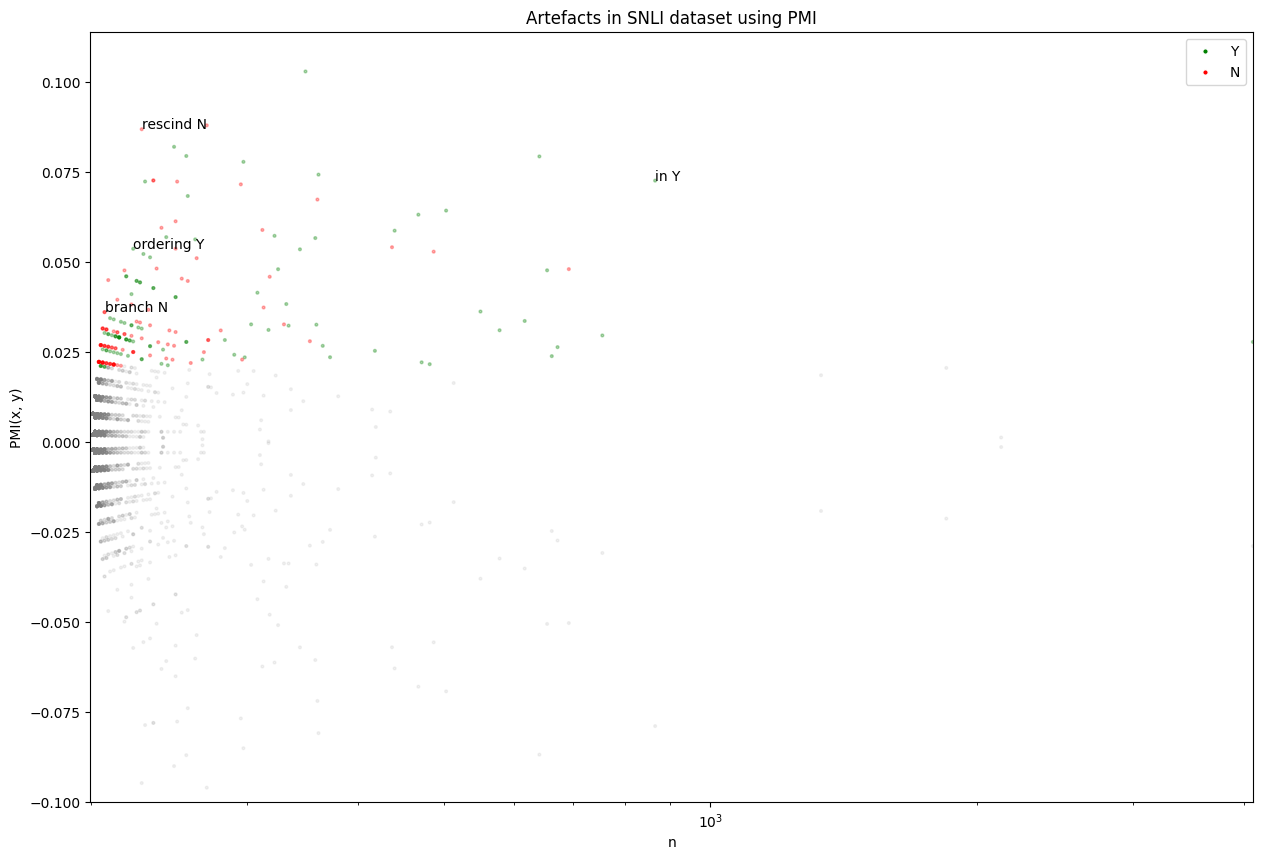

In [ ]:
# Define the figure and axes for the plot
fig, ax = plt.subplots(figsize=(15,10))

# Define a dictionary of colors for each label
colors = {'Y': 'g', 'N': 'r', 'grey': 'grey'}

# Define a dictionary of words to annotate in the plot for each label
token_label_annotate_dict = {
    'N': ['rescind', 'branch'],
    'Y': ['in', 'ordering']
}

# Plot the PMI for each token and label
for label in labels:
    # Create a condition series to find which points are above the threshold
    is_above_threshold = smoothed_token_df[f'{label}_pmi'] > pmi_thresholds[label]

    # Create a color and alpha series based on the condition series
    color_series = pd.Series(colors['grey'], index=smoothed_token_df.index)
    color_series[is_above_threshold] = colors[label]

    alpha_series = pd.Series(0.1, index=smoothed_token_df.index)
    alpha_series[is_above_threshold] = 0.3

    # Plot the points for this label
    ax.scatter(smoothed_token_df['total_count'], smoothed_token_df[f'{label}_pmi'], c=color_series, alpha=alpha_series, s=4)

    # Add annotations for selected words
    for token in set(token_label_annotate_dict[label]) & set(smoothed_token_df['token']):
        x = smoothed_token_df.loc[smoothed_token_df['token'] == token, 'total_count'].values[0]
        y = smoothed_token_df.loc[smoothed_token_df['token'] == token, f'{label}_pmi'].values[0]
        ax.annotate(f'{token} {label[0]}', (x, y))

# Adjust x-axis to be logarithmic and limit its range
ax.set_xscale('log')
ax.set_xlim([10**2.3, max(smoothed_token_df['total_count'])])

ax.set_ylim([-0.1, ax.get_ylim()[1]])

# Hide the first x-axis label
# ax.xaxis.get_major_ticks()[0].label1.set_visible(False)

# Set the labels for the x and y axes, and the title for the plot
ax.set_xlabel('n')
ax.set_ylabel('PMI(x, y)')
ax.set_title('Artefacts in SNLI dataset using PMI')

# Create custom legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label=label,
                          markerfacecolor=color, markersize=4) for label, color in colors.items() if label != 'grey']
ax.legend(handles=legend_elements, loc='upper right')

# Display the plot
plt.show()


In [ ]:
plt.savefig('plots/2018/train/coliee_2018_pmi_artefacts_chart.svg', dpi=150)

<Figure size 640x480 with 0 Axes>

In [ ]:
# Create an interactive scatter plot using Plotly

# Define a new figure
fig = go.Figure()

# Define a dictionary of colors for each label
colors = {'Y': 'green', 'N': 'red', 'grey': 'grey'}

# Plot the PMI for each token and label
for label in labels:
    # Get the DataFrame for the current label
    data_label = smoothed_token_df

    # Determine which points are above the threshold
    is_above_threshold = data_label[f'{label}_pmi'] > pmi_thresholds[label]

    # Add scatter plots for points above and below the threshold
    for condition, color in zip([is_above_threshold, ~is_above_threshold], [colors[label], 'grey']):
        token = data_label[condition]['token']
        text = [f"Label: {label}<br>Token: {t}" for t in token]
        fig.add_trace(go.Scatter(
            x = data_label[condition]['total_count'],
            y = data_label[condition][f'{label}_pmi'],
            mode = 'markers',
            name = label if color != 'grey' else None,
            marker = dict(
                color = color,
                size = 4
            ),
            text = text,
            hovertemplate = "%{text}<br>Occurrences: %{x}<br>PMI: %{y}<extra></extra>"
        ))

# Set the scale of the x-axis to logarithmic and limit its range
fig.update_xaxes(type='log', range=[2.3, np.log10(max(token_df['total_count']))])

# Set the labels for the x and y axes, and the title for the plot
fig.update_layout(
    xaxis_title='n',
    yaxis_title='PMI(x, y)',
    title='Artefacts in SNLI dataset'
)

# Display the plot
fig.show()


Analysis of Top N words associated with each label in the NLI data

In [ ]:
# Number of top words to display
n_top_words = 10

# For each label, display the top n words by PMI
for label in labels:
    top_words_df = smoothed_token_df.nlargest(n_top_words, f"{label}_pmi")[["token", f"{label}_count"]]
    # percentage of the token that occurs in the sentences of a particular label
    top_words_df[f"{label}_percentage"] = top_words_df[f"{label}_count"] / total_label_counts[label] * 100
    print(f"\nTop {n_top_words} words affiliated with '{label}' by PMI:")
    print(top_words_df.to_string(index=False))


# The top words match with the table 4 presented in the paper but the percentages are different. This might be due to a calculation error?



Top 10 words affiliated with 'Y' by PMI:
   token  Y_count  Y_percentage
    such      194      0.084935
  defect      135      0.059104
     can      139      0.060855
    that      348      0.152357
building      161      0.070487
      or      195      0.085372
      in      467      0.204456
     yen      124      0.054288
    work      138      0.060417
  person      269      0.117770

Top 10 words affiliated with 'N' by PMI:
   token  N_count  N_percentage
property      147      0.064732
 rescind      124      0.054604
    real      126      0.055485
      do      126      0.055485
  effect      134      0.059007
    sale      158      0.069576
    even      192      0.084548
  unless      132      0.058127
  pledge      127      0.055925
     was      165      0.072658


# Sentence Length as an Artefact

In [ ]:
# coliee_train dataframe contains the hypothesis sentences and the labels
coliee_train.head()

,id,label,premise,hypothesis,labels,tokens
0,H18-1-1,0,Article 572\nEven if the seller makes a specia...,A special provision that releases warranty can...,Y,"[a, special, provision, that, releases, warran..."
1,H18-1-2,1,Article 565\nThe provisions of the preceding t...,There is a limitation period on pursuance of w...,N,"[there, is, a, limitation, period, on, pursuan..."
2,H18-1-3,1,Article 568\n(1) The successful bidder at an a...,"A compulsory auction is also a sale, so warran...",N,"[a, compulsory, auction, is, also, a, sale, so..."
3,H18-2-1,0,Article 697\n(1) A person that has begun to ma...,In cases where a person plans to prevent crime...,Y,"[in, cases, where, a, person, plans, to, preve..."
4,H18-2-2,0,Article 698\nIf a manager engages in benevolen...,In cases where an individual rescues another p...,Y,"[in, cases, where, an, individual, rescues, an..."


In [ ]:
# create a new dataframe with the hypothesis sentences and the labels
hypothesis_length_df = coliee_train[['hypothesis', 'labels']]

In [ ]:
hypothesis_length_df

,hypothesis,labels
0,A special provision that releases warranty can...,Y
1,There is a limitation period on pursuance of w...,N
2,"A compulsory auction is also a sale, so warran...",N
3,In cases where a person plans to prevent crime...,Y
4,In cases where an individual rescues another p...,Y
...,...,...
882,The postponement of expiry of prescription per...,N
883,A universal successor to a possessor may also ...,Y
884,A claim that a co-owner (A) holds against anot...,N
885,If the obligor of an alternative obligation ma...,Y


In [ ]:
# split the hypothesis sentences into tokens and calculate the length of each sentence again
# because the preprocessing steps in the paper are not clear

hypothesis_length_df['tokens'] = hypothesis_length_df['hypothesis'].apply(lambda x: x.split())

hypothesis_length_df['length'] = hypothesis_length_df['tokens'].apply(lambda x: len(x))

/var/folders/w5/q2d0spjx14x5z8h5hlljhxfr0000gn/T/ipykernel_40681/1474729126.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/w5/q2d0spjx14x5z8h5hlljhxfr0000gn/T/ipykernel_40681/1474729126.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
hypothesis_length_df

,hypothesis,labels,tokens,length
0,A special provision that releases warranty can...,Y,"[A, special, provision, that, releases, warran...",35
1,There is a limitation period on pursuance of w...,N,"[There, is, a, limitation, period, on, pursuan...",41
2,"A compulsory auction is also a sale, so warran...",N,"[A, compulsory, auction, is, also, a, sale,, s...",18
3,In cases where a person plans to prevent crime...,Y,"[In, cases, where, a, person, plans, to, preve...",32
4,In cases where an individual rescues another p...,Y,"[In, cases, where, an, individual, rescues, an...",41
...,...,...,...,...
882,The postponement of expiry of prescription per...,N,"[The, postponement, of, expiry, of, prescripti...",30
883,A universal successor to a possessor may also ...,Y,"[A, universal, successor, to, a, possessor, ma...",14
884,A claim that a co-owner (A) holds against anot...,N,"[A, claim, that, a, co-owner, (A), holds, agai...",26
885,If the obligor of an alternative obligation ma...,Y,"[If, the, obligor, of, an, alternative, obliga...",36


In [ ]:
# group the dataframe by the labels
grouped = hypothesis_length_df.groupby("labels")

# Initialize a list to hold the length distributions
length_distributions_list = []

for label, group_df in grouped:
    # Calculate the length distribution for this group
    length_distribution = group_df["length"].value_counts(normalize=True).rename("probability").reset_index()
    length_distribution["labels"] = label  # Add the label column

    # Add this distribution to the list
    length_distributions_list.append(length_distribution)

# Concatenate all the distributions into one DataFrame
length_distributions = pd.concat(length_distributions_list)


In [ ]:
length_distributions = length_distributions.sort_values(by=['length'])
length_distributions

,length,probability,labels
73,6,0.002237,Y
64,6,0.002273,N
54,7,0.004545,N
53,7,0.004474,Y
70,8,0.002237,Y
...,...,...,...
74,107,0.002237,Y
70,109,0.002273,N
68,110,0.002273,N
75,127,0.002237,Y


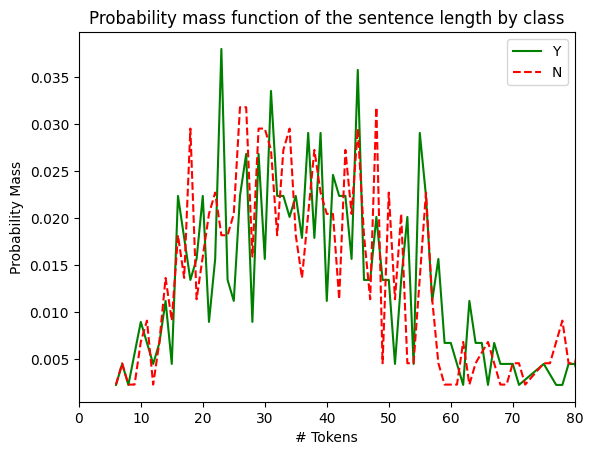

In [ ]:
# Initialize the plot
fig, ax = plt.subplots()

# give different line styles to each label
linestyle = {
    "Y": "-",
    "N": "dashed"
}

# provide different colors to each label
colors = {
    "Y": "g",
    "N": "r"
}


# For each label, plot the probability mass function
for label in labels:
    data_label = length_distributions[length_distributions["labels"] == label]
    ax.plot(data_label["length"], data_label["probability"],
            label=label, linestyle=linestyle[label], color=colors[label])

# Set the labels and title for the plot
ax.set_xlabel("# Tokens")
ax.set_ylabel("Probability Mass")
ax.set_title("Probability mass function of the sentence length by class")
ax.legend()

ax.set_xlim([0, 80])

# Display the plot
plt.show()


In [ ]:
print(f"Mean length of the hypothesis sentences for label N: {hypothesis_length_df[hypothesis_length_df['labels']=='N']['length'].mean()}")
print(f"Mean length of the hypothesis sentences for label Y: {hypothesis_length_df[hypothesis_length_df['labels']=='Y']['length'].mean()}")
print(f"Median length of the hypothesis sentences for label N: {hypothesis_length_df[hypothesis_length_df['labels']=='N']['length'].median()}")
print(f"Median length of the hypothesis sentences for label Y: {hypothesis_length_df[hypothesis_length_df['labels']=='Y']['length'].median()}")

Mean length of the hypothesis sentences for label N: 38.16818181818182
Mean length of the hypothesis sentences for label Y: 40.52125279642058
Median length of the hypothesis sentences for label N: 35.0
Median length of the hypothesis sentences for label Y: 38.0


In [ ]:
hypothesis_length_df['length'].describe()

count    887.000000
mean      39.354002
std       18.933913
min        6.000000
25%       26.000000
50%       37.000000
75%       48.500000
max      149.000000
Name: length, dtype: float64

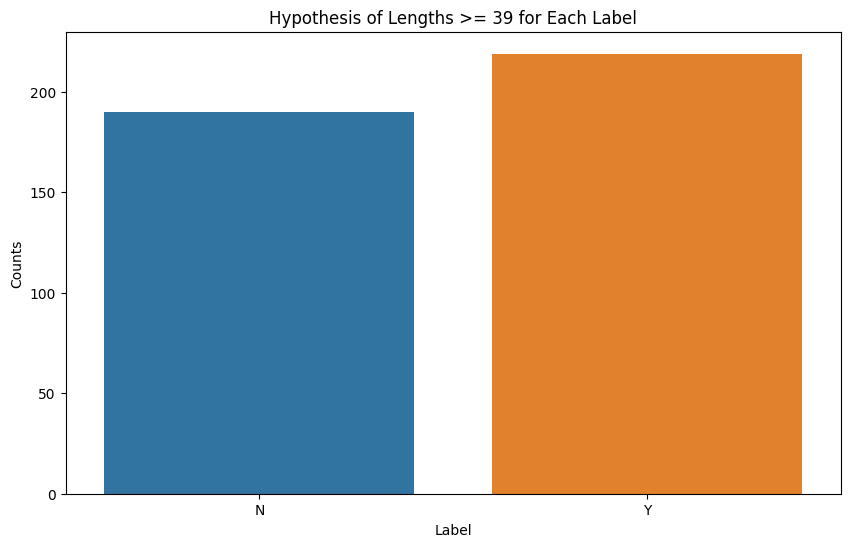

In [ ]:
threshold = 39

filtered_df = hypothesis_length_df[hypothesis_length_df['length'] >= threshold]

# Then, group by 'label' and count the number of 'length' entries for each 'label'
grouped_counts = filtered_df.groupby('labels')['length'].count()

# Plot the counts
plt.figure(figsize=(10, 6))
sns.barplot(x=grouped_counts.index, y=grouped_counts.values)
plt.title(f'Hypothesis of Lengths >= {threshold} for Each Label')
plt.xlabel('Label')
plt.ylabel('Counts')
plt.show()

# Word Overlap Bias

In [ ]:
def calculate_overlap(premise, hypothesis):
    """
    This function takes in two sentences as arguments (the premise and the hypothesis), tokenizes them,
    and calculates the count of words that overlap between them if the overlap is high (above the threshold).
    The threshold is defined as a ratio of the total words in both sentences.
    """

    # Tokenize the sentences
    premise_tokens = nltk.word_tokenize(premise.lower())
    hypothesis_tokens = nltk.word_tokenize(hypothesis.lower())

    # Count the words in each sentence
    premise_counter = Counter(premise_tokens)
    hypothesis_counter = Counter(hypothesis_tokens)

    # Calculate the overlap using the intersection of the two Counters
    overlap_counter = premise_counter & hypothesis_counter
    overlap = sum(overlap_counter.values())

    return overlap

def detect_word_overlap_bias(df):
    """
    This function takes in a dataframe with 'premise', 'hypothesis', and 'label' columns,
    calculates the number of overlapping words for each row and adds this as a new 'overlap' column,
    then calculates the average overlap for 'entailment' cases and for 'non-entailment' cases,
    and compares the two.
    It also counts the number of instances in the 'entailment' and 'non-entailment' cases
    where the overlap is above a given threshold.
    """

    # Calculate overlap for each row and add it as a new 'overlap' column
    df['overlap'] = df.apply(lambda row: calculate_overlap(row['premise'], row['hypothesis']), axis=1)

    return df

In [ ]:
wob_df = detect_word_overlap_bias(coliee_train)

In [ ]:
wob_df

,id,label,premise,hypothesis,labels,tokens,overlap
0,H18-1-1,0,Article 572\nEven if the seller makes a specia...,A special provision that releases warranty can...,Y,"[a, special, provision, that, releases, warran...",22
1,H18-1-2,1,Article 565\nThe provisions of the preceding t...,There is a limitation period on pursuance of w...,N,"[there, is, a, limitation, period, on, pursuan...",18
2,H18-1-3,1,Article 568\n(1) The successful bidder at an a...,"A compulsory auction is also a sale, so warran...",N,"[a, compulsory, auction, is, also, a, sale, so...",10
3,H18-2-1,0,Article 697\n(1) A person that has begun to ma...,In cases where a person plans to prevent crime...,Y,"[in, cases, where, a, person, plans, to, preve...",15
4,H18-2-2,0,Article 698\nIf a manager engages in benevolen...,In cases where an individual rescues another p...,Y,"[in, cases, where, an, individual, rescues, an...",16
...,...,...,...,...,...,...,...
882,R02-36-I,1,Article 153 (1) The postponement of the expiry...,The postponement of expiry of prescription per...,N,"[the, postponement, of, expiry, of, prescripti...",29
883,R02-36-U,0,Article 187 (1) A successor to a possessor may...,A universal successor to a possessor may also ...,Y,"[a, universal, successor, to, a, possessor, ma...",14
884,R02-36-E,1,Article 254 A claim that one of the co-owners ...,A claim that a co-owner (A) holds against anot...,N,"[a, claim, that, a, coowner, a, holds, against...",19
885,R02-37-A,0,Article 406 If the subject matter of the claim...,If the obligor of an alternative obligation ma...,Y,"[if, the, obligor, of, an, alternative, obliga...",27


In [ ]:
wob_df['overlap'].describe()

count    887.000000
mean      24.177001
std       12.566088
min        0.000000
25%       15.000000
50%       22.000000
75%       31.000000
max       86.000000
Name: overlap, dtype: float64

In [ ]:
entailment_wob_df = wob_df[wob_df['labels'] == 'Y']
non_entailment_wob_df = wob_df[wob_df['labels'] == 'N']

# print number of instances
print(f'Number of total cases: {wob_df.shape[0]}')
print(f'Number of entailment cases: {entailment_wob_df.shape[0]}')
print(f'Number of non-entailment cases: {non_entailment_wob_df.shape[0]}')

Number of total cases: 887
Number of entailment cases: 447
Number of non-entailment cases: 440


In [ ]:
entailment_wob_df['overlap'].describe()

count    447.000000
mean      25.393736
std       12.941287
min        0.000000
25%       16.000000
50%       24.000000
75%       33.000000
max       86.000000
Name: overlap, dtype: float64

In [ ]:
non_entailment_wob_df['overlap'].describe()

count    440.000000
mean      22.940909
std       12.062523
min        2.000000
25%       14.000000
50%       21.000000
75%       29.250000
max       76.000000
Name: overlap, dtype: float64

The number of entailment cases with overlap above 50 is 21
The number of non-entailment cases with overlap above 50 is 12


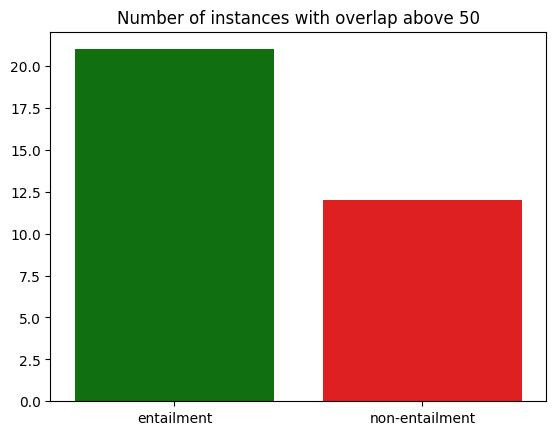

In [ ]:
ov_threshold = 50

n_overlap_entailment = entailment_wob_df[entailment_wob_df['overlap'] > ov_threshold]

n_overlap_contradiction = non_entailment_wob_df[non_entailment_wob_df['overlap'] > ov_threshold]

print(f"The number of entailment cases with overlap above {ov_threshold} is {n_overlap_entailment.shape[0]}")
print(f"The number of non-entailment cases with overlap above {ov_threshold} is {n_overlap_contradiction.shape[0]}")

# Data
labels = ['entailment', 'non-entailment']
counts = [n_overlap_entailment.shape[0], n_overlap_contradiction.shape[0]]

# Create the bar plot
sns.barplot(x=labels, y=counts, palette=['g', 'r'])
plt.title(f'Number of instances with overlap above {ov_threshold}')
plt.show()



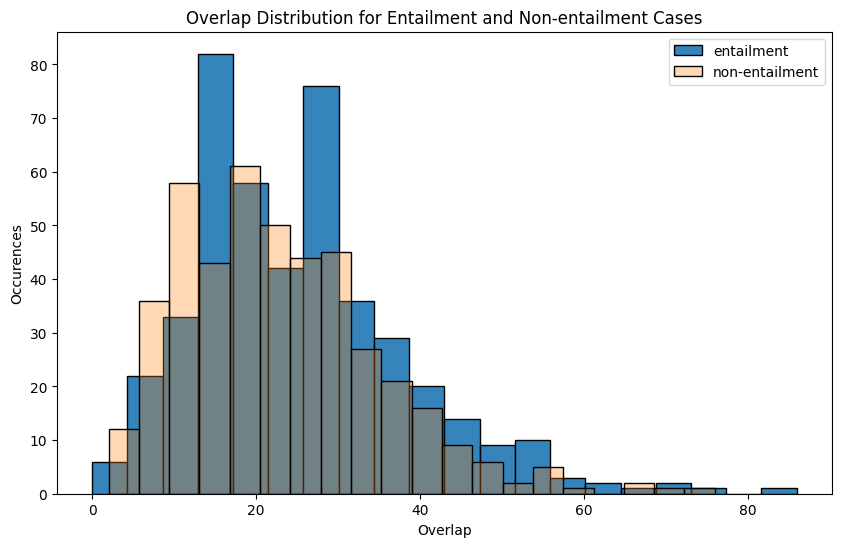

In [ ]:
plt.figure(figsize=(10, 6))

sns.histplot(entailment_wob_df['overlap'], label='entailment', bins=20,  alpha=0.9)
sns.histplot(non_entailment_wob_df['overlap'], label='non-entailment', bins=20, alpha=0.3)

plt.title('Overlap Distribution for Entailment and Non-entailment Cases')
plt.xlabel('Overlap')
plt.ylabel('Occurences')
plt.legend(loc='upper right')

plt.show()

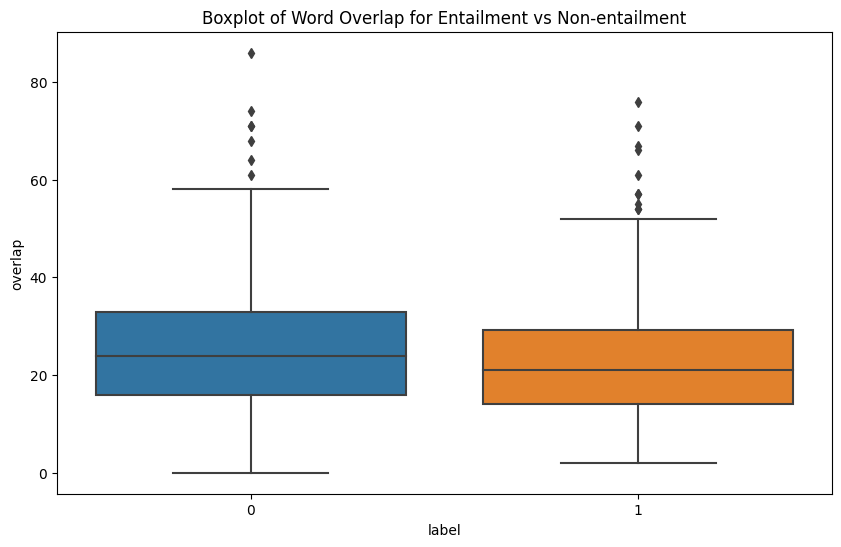

In [ ]:
# Combine the dataframes into one for easier plotting
combined_df = pd.concat([entailment_wob_df, non_entailment_wob_df])

# Create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='overlap', data=combined_df)
plt.title('Boxplot of Word Overlap for Entailment vs Non-entailment')
plt.show()


# Contradiction Word Bias

In [ ]:
# Load the dataset
cwb_df = coliee_train[['premise','hypothesis','labels']]

# Load a SpaCy model and disable unneeded components
nlp = spacy.load('en_core_web_sm', disable=['tagger', 'ner'])

# List of negation words
# The word cannot is not listed as spacy tokenizes it as can and not.
negation_words = ["not", "no", "n't", "none", "neither", "never", "nobody", "nothing", "nowhere", "hardly", "scarcely", "barely", "rarely", "seldom"]

# Function to count the number of negations in a sentence
def extract_negations(doc):
    return [token.text for token in doc if token.text.lower() in negation_words]

# Use the pipe method to process the texts in batches
docs = list(nlp.pipe(cwb_df['hypothesis']))

# Apply the function to each Doc object
cwb_df['negations'] = [extract_negations(doc) for doc in docs]
# create a new column to store the number of negations in each sentence
cwb_df['negation_count'] = cwb_df['negations'].apply(lambda x: len(x))
# Create the contains_negation column
cwb_df['contains_negation'] = cwb_df['negation_count'] > 0


/Users/venkateshmurugadas/.pyenv/versions/3.10.0/envs/thesis/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning:

[W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.

/var/folders/w5/q2d0spjx14x5z8h5hlljhxfr0000gn/T/ipykernel_40681/1624724495.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/w5/q2d0spjx14x5z8h5hlljhxfr0000gn/T/ipykernel_40681/1624724495.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

In [ ]:
# calculate the top negation words for each label
labels = cwb_df['labels'].unique().tolist()
for label in labels:
    top_words_df = cwb_df[cwb_df['labels'] == label].nlargest(5, 'negation_count')[['negations', 'negation_count']]
    print(f"\nTop 10 negation words affiliated with '{label}':")
    print(top_words_df.to_string(index=False))


Top 10 negation words affiliated with 'Y':
              negations  negation_count
[no, not, not, no, not]               5
        [not, not, not]               3
        [not, not, not]               3
        [not, not, not]               3
         [not, not, no]               3

Top 10 negation words affiliated with 'N':
                negations  negation_count
[not, not, not, not, not]               5
   [no, not, no, no, not]               5
     [not, not, not, not]               4
           [not, no, not]               3
          [not, not, not]               3


In [ ]:
# flatten the list of negations
negations_list = [negation for negations in cwb_df['negations'] for negation in negations]
negation_counter = Counter(negations_list)

negation_counter

Counter({'not': 541, 'no': 55, 'No': 9, "n't": 4, 'neither': 2})

In [ ]:
# Split the dataframe into entailment and non-entailment cases
entailment_df = cwb_df[cwb_df['labels'] == 'Y']
non_entailment_df = cwb_df[cwb_df['labels'] == 'N']

# Calculate the average number of negations for entailment and non-entailment cases
avg_negations_entailment = entailment_df['negation_count'].mean()
avg_negations_non_entailment = non_entailment_df['negation_count'].mean()

print(f"The average number of negations in entailment cases is {avg_negations_entailment}")
print(f"The average number of negations in non-entailment cases is {avg_negations_non_entailment}")


The average number of negations in entailment cases is 0.6331096196868009
The average number of negations in non-entailment cases is 0.7454545454545455


In [ ]:
contradiction_with_neg_instances = cwb_df[(cwb_df['contains_negation'] == True) & (cwb_df['labels'] == 'N')]
contradiction_without_neg_instances = cwb_df[(cwb_df['contains_negation'] == False) & (cwb_df['labels'] == 'N')]

entailment_with_neg_instances = cwb_df[(cwb_df['contains_negation'] == True) & (cwb_df['labels'] == 'Y')]
entailment_without_neg_instances = cwb_df[(cwb_df['contains_negation'] == False) & (cwb_df['labels'] == 'Y')]

print(f"Number of contradiction cases with negation: {contradiction_with_neg_instances.shape[0]}")
# percentage of contradiction cases with negation
total_contradiction_instances = contradiction_with_neg_instances.shape[0] + contradiction_without_neg_instances.shape[0]
print(f"Percentage of contradiction cases with negation: {contradiction_with_neg_instances.shape[0]/(total_contradiction_instances)}")

print(f"Number of entailment cases with negation: {entailment_with_neg_instances.shape[0]}")
# percentage of entailment cases with negation
total_entailment_instances = entailment_with_neg_instances.shape[0] + entailment_without_neg_instances.shape[0]
print(f"Percentage of entailment cases with negation: {entailment_with_neg_instances.shape[0]/(total_entailment_instances)}")

Number of contradiction cases with negation: 247
Percentage of contradiction cases with negation: 0.5613636363636364
Number of entailment cases with negation: 218
Percentage of entailment cases with negation: 0.48769574944071586


Number of contradiction instances with negation: 247
Number of entailment instances with negation: 218


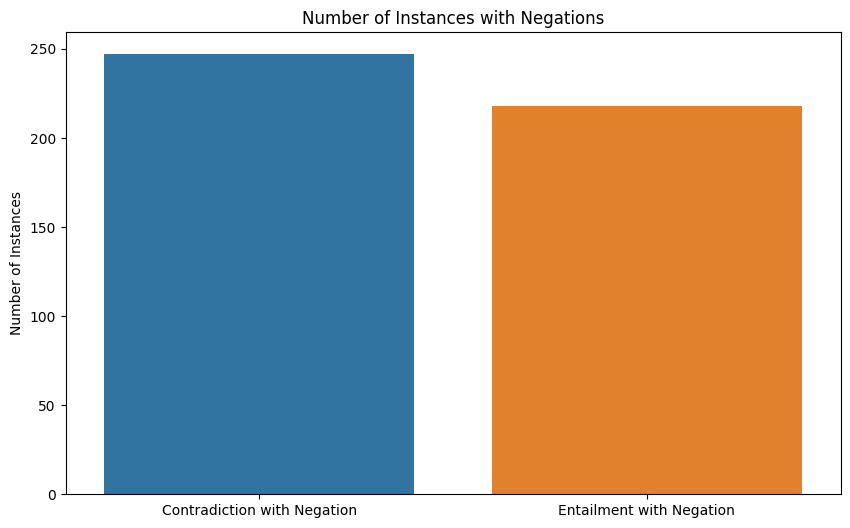

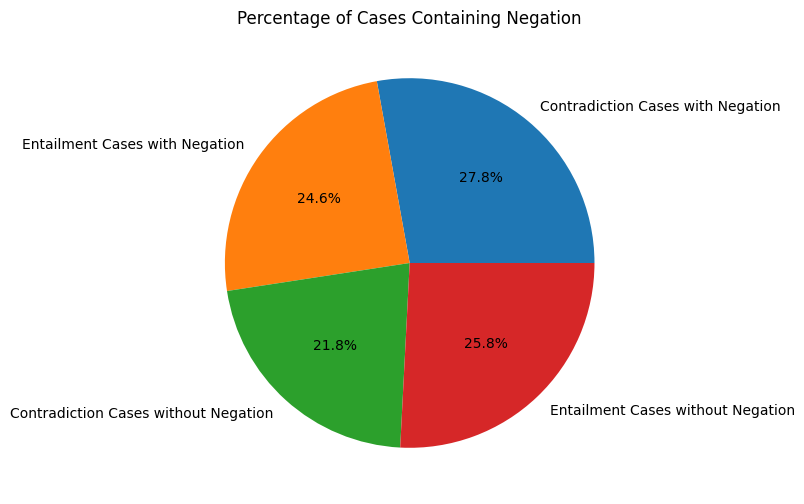

Total number of negation words in the contradiction instances 328
Total number of negation words in the entailment instances 283


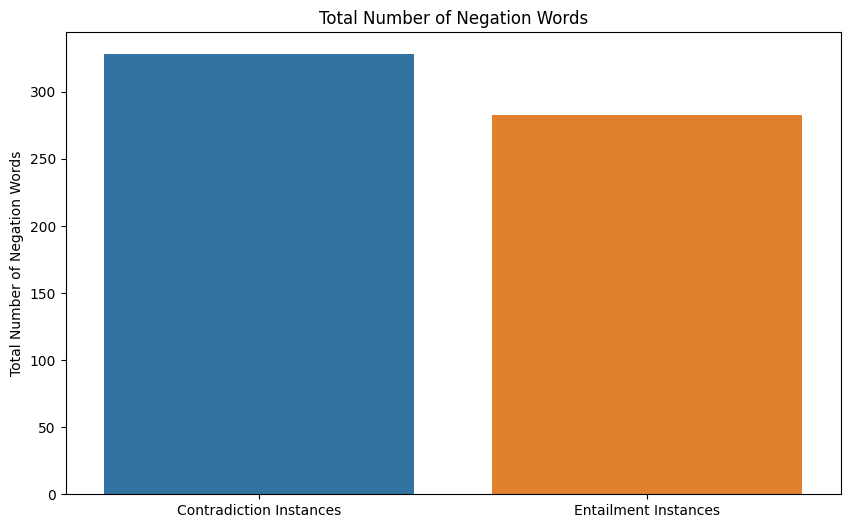

Percentage of contradiction cases with negation: 0.5613636363636364
Percentage of entailment cases with negation: 0.48769574944071586


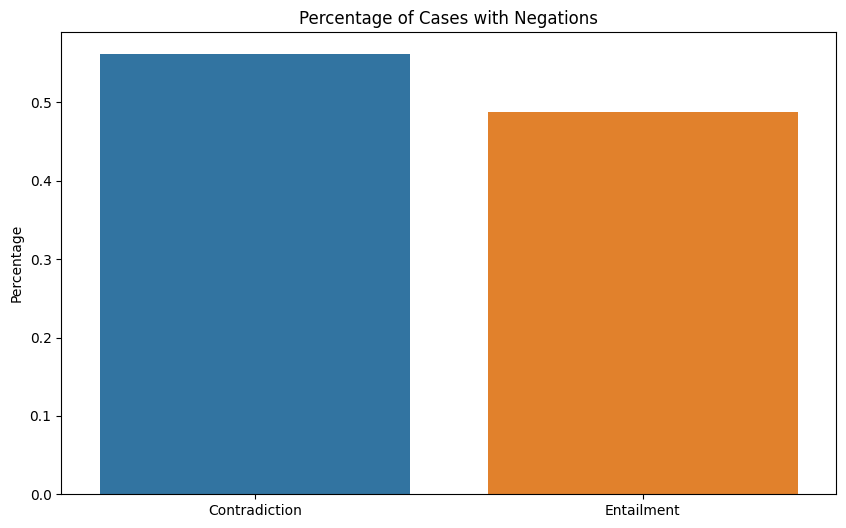

The average number of negations in entailment cases is 0.6331096196868009
The average number of negations in non-entailment cases is 0.7454545454545455


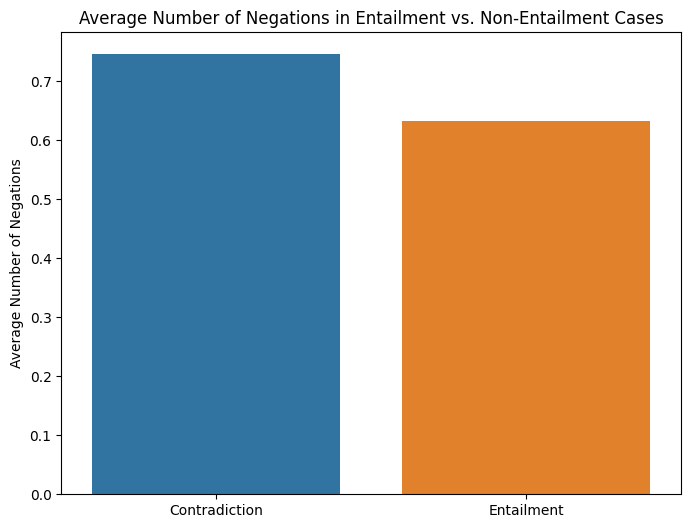

In [ ]:
# Bar Plot for number of cases with negations
print(f"Number of contradiction instances with negation: {contradiction_with_neg_instances.shape[0]}")
print(f"Number of entailment instances with negation: {entailment_with_neg_instances.shape[0]}")
labels = ['Contradiction with Negation', 'Entailment with Negation']
values = [contradiction_with_neg_instances.shape[0],
          entailment_with_neg_instances.shape[0]]

plt.figure(figsize=(10, 6))
sns.barplot(x=labels, y=values)
plt.title('Number of Instances with Negations')
plt.ylabel('Number of Instances')
plt.show()

# Pie Chart of Cases with Negation
labels = ['Contradiction Cases with Negation', 'Entailment Cases with Negation', 'Contradiction Cases without Negation', 'Entailment Cases without Negation']
sizes = [contradiction_with_neg_instances.shape[0], entailment_with_neg_instances.shape[0], contradiction_without_neg_instances.shape[0], entailment_without_neg_instances.shape[0]]
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Percentage of Cases Containing Negation')
plt.show()

# Bar Plot for total number of negations in contradiction and entailment instances
print(f"Total number of negation words in the contradiction instances {contradiction_with_neg_instances['negation_count'].sum()}")
print(f"Total number of negation words in the entailment instances {entailment_with_neg_instances['negation_count'].sum()}")
labels = ['Contradiction Instances', 'Entailment Instances']
values = [contradiction_with_neg_instances['negation_count'].sum(), entailment_with_neg_instances['negation_count'].sum()]

plt.figure(figsize=(10, 6))
sns.barplot(x=labels, y=values)
plt.title('Total Number of Negation Words')
plt.ylabel('Total Number of Negation Words')
plt.show()

# Bar Plot for percentage of cases with negations
print(f"Percentage of contradiction cases with negation: {contradiction_with_neg_instances.shape[0]/(total_contradiction_instances)}")
print(f"Percentage of entailment cases with negation: {entailment_with_neg_instances.shape[0]/(total_entailment_instances)}")
labels = ['Contradiction', 'Entailment']
values = [contradiction_with_neg_instances.shape[0] / (total_contradiction_instances),
          entailment_with_neg_instances.shape[0] / (total_entailment_instances)]

plt.figure(figsize=(10, 6))
sns.barplot(x=labels, y=values)
plt.title('Percentage of Cases with Negations')
plt.ylabel('Percentage')
plt.show()


# Bar Chart of Average Negation Counts
print(f"The average number of negations in entailment cases is {avg_negations_entailment}")
print(f"The average number of negations in non-entailment cases is {avg_negations_non_entailment}")
plt.figure(figsize=(8, 6))
sns.barplot(x=['Contradiction', 'Entailment'], y=[avg_negations_non_entailment, avg_negations_entailment])
plt.title('Average Number of Negations in Entailment vs. Non-Entailment Cases')
plt.ylabel('Average Number of Negations')
plt.show()



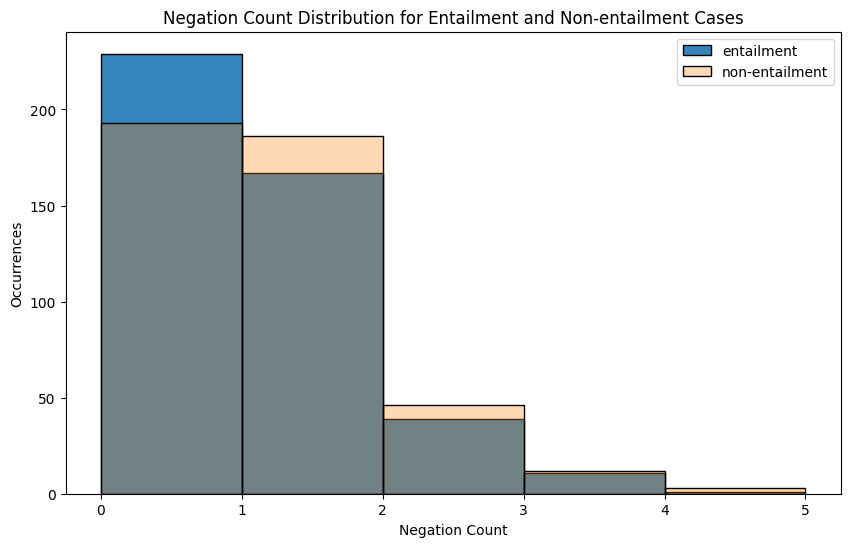

In [ ]:
# Histogram of Negation Counts for Entailment and Non-entailment Cases
plt.figure(figsize=(10, 6))

sns.histplot(entailment_df['negation_count'], label='entailment', bins=5, alpha=0.9)
sns.histplot(non_entailment_df['negation_count'], label='non-entailment', bins=5, alpha=0.3)

plt.title('Negation Count Distribution for Entailment and Non-entailment Cases')
plt.xlabel('Negation Count')
plt.ylabel('Occurrences')
plt.legend(loc='upper right')

plt.show()


# Subsequence Heuristic bias

In [ ]:
ssb_df = coliee_train[['premise','hypothesis','labels']]

In [ ]:
def remove_punctuation(input_string):
    translator = str.maketrans('', '', string.punctuation)
    return input_string.translate(translator)

def detect_subsequence(premise: str, hypothesis: str) -> Tuple[str, bool]:
    premise_words = remove_punctuation(premise.lower())
    hypothesis_words = remove_punctuation(hypothesis.lower())
    # Add word boundaries to the hypothesis
    hypothesis_words = r"\b" + hypothesis_words + r"\b"
    if re.search(hypothesis_words, premise_words):
        return (hypothesis, True)
    else:
        return ("", False)

In [ ]:
# test cases for the subsequence heuristic function

def test_detect_subsequence():
    result = detect_subsequence(
        "The artist and the student called the judge.",
        "The student called the judge.")
    assert result == ("The student called the judge.", True), f'Expected ("The student called the judge.", True), but got {result}'
    result = detect_subsequence(
        "The judges heard the actors resigned.",
        "The judges heard the actors")
    assert result == ("The judges heard the actors", True), f'Expected ("The judges heard the actors", True), but got {result}'
    result = detect_subsequence(
        "The judges heard the actors resigned.",
        "The judges and the actors resigned")
    assert result == ("", False), f'Expected ("", False), but got {result}'
    result = detect_subsequence(
        "The artist and the student called the judge.",
        "The artist called the judge")
    assert result == ("", False), f'Expected ("", False), but got {result}'
    result = detect_subsequence(
        "The artist and the student called the judge.",
        "The student called")
    assert result == ("The student called", True), f'Expected ("The student called", True), but got {result}'
    result = detect_subsequence(
        "The artist and the student called the judge.",
        "The judge called the student")
    assert result == ("", False), f'Expected ("", False), but got {result}'
    print("All tests passed.")

test_detect_subsequence()

All tests passed.


In [ ]:
ssb_df['detected_subsequence'], ssb_df['is_subsequence_heuristic'] = zip(*ssb_df.apply(lambda row: detect_subsequence(row['premise'], row['hypothesis']), axis=1))

/var/folders/w5/q2d0spjx14x5z8h5hlljhxfr0000gn/T/ipykernel_40681/468833950.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/w5/q2d0spjx14x5z8h5hlljhxfr0000gn/T/ipykernel_40681/468833950.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
ssb_df['detected_subsequence'][ssb_df['detected_subsequence']!=""].head(30)

380    A mandatary must, if so requested by the manda...
390    If costs will be incurred in administering the...
585    If two buildings are owned by different owners...
727    A landowner may install boundary markers, shar...
809    If the assistant does not consent to an act fo...
832    An underground space or airspace may be establ...
833    In order to preserve the effectiveness of stat...
854    Unless the parties manifest a particular inten...
866    If it comes to no longer be possible to use or...
875    Even if the duration of the partnership is spe...
Name: detected_subsequence, dtype: object

In [ ]:
ssb_df_entailment = ssb_df[(ssb_df['is_subsequence_heuristic']==True) & (ssb_df['labels']=='Y')]
ssb_df_contradiction = ssb_df[(ssb_df['is_subsequence_heuristic']==True) & (ssb_df['labels']=='N')]

print(f"Number of entailment cases with subsequence heuristic: {ssb_df_entailment.shape[0]}")
print(f"Number of contradiction cases with subsequence heuristic: {ssb_df_contradiction.shape[0]}")

Number of entailment cases with subsequence heuristic: 10
Number of contradiction cases with subsequence heuristic: 0


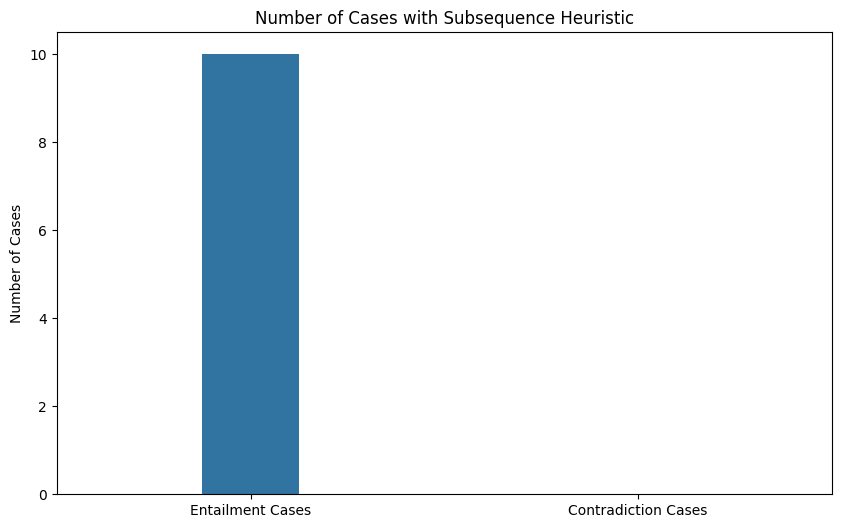

In [ ]:
# Bar Plot for number of cases with subsequence heuristic
labels = ['Entailment Cases', 'Contradiction Cases']
values = [ssb_df_entailment.shape[0], ssb_df_contradiction.shape[0]]

plt.figure(figsize=(10, 6))
sns.barplot(x=labels, y=values, width=0.25)
plt.title('Number of Cases with Subsequence Heuristic')
plt.ylabel('Number of Cases')
plt.show()
